In [ ]:
import pandas as pd
import sklearn
from sklearn.svm import SVR
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from fbprophet import Prophet
import torch, numpy as np, torch.nn as nn
from torch.autograd import variable
import torchvision.transforms as transforms, torchvision.datasets as dsets

Index(['Date', 'Date_YMD', 'Daily Confirmed', 'Total Confirmed',
       'Daily Recovered', 'Total Recovered', 'Daily Deceased',
       'Total Deceased'],
      dtype='object')
(240, 3)


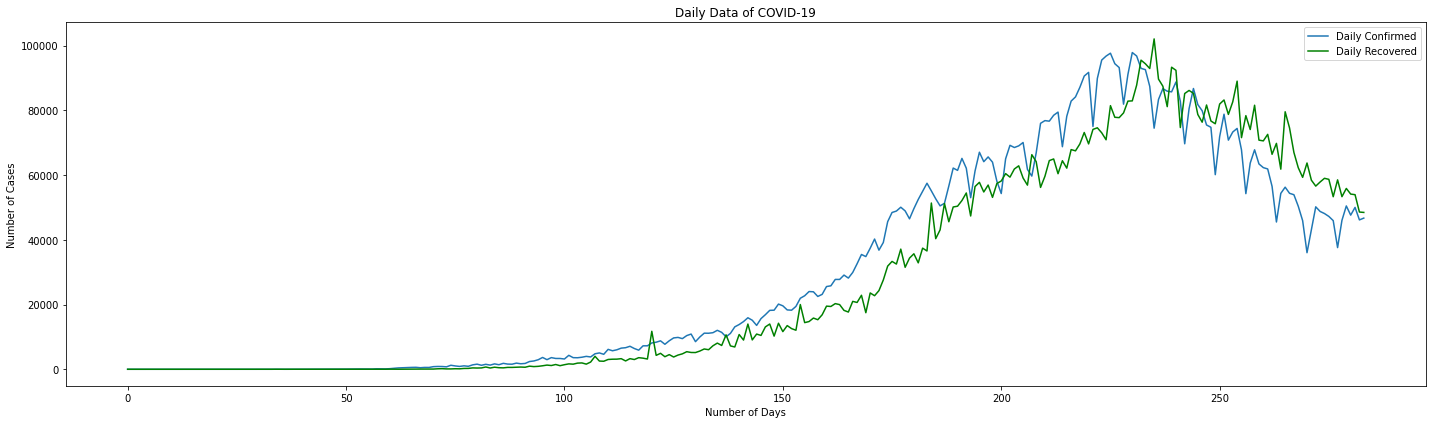

In [ ]:
df = pd.read_csv("case_time_series_final.csv")
#df['Date'] = pd.to_datetime(df['Date'])
print(df.columns)

#increase = df['Daily Confirmed'] - df['Daily Recovered'] - df['Daily Deceased']
fig,(a1) = plt.subplots(figsize=(20, 6))
a1.plot(df['Daily Confirmed'], label = "Daily Confirmed")
#a1.set_title('Daily Confirmed')
a1.plot(df['Daily Recovered'],label="Daily Recovered", color = 'green')
a1.set_ylabel("Number of Cases")
a1.set_xlabel("Number of Days")
a1.set_title('Daily Data of COVID-19')
a1.legend()

#a1.set_title('Daily Recovered')
#a1.plot(df['Total Deceased'], color= 'red')
#a1.set_title('Daily Deceased')
#a1.plot(increase, color= 'black')
#a1.set_title('Daily Increase')  # from this grapg we can infer that lately the number of increase in daily positive patients is going down (i.e no of people testing positive is less when compared to number of people getting recovered or deaths reported)
fig.tight_layout()



df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
dff = pd.read_csv("sorted_data_state_daily.csv")
dfc = dff.iloc[:240, :]
dfd = dff.iloc[240:480, :]
dfr = dff.iloc[480:720, :]

dfc_mh = dfc["MH"]
dfr_mh = dfr["MH"]
dfd_mh = dfd["MH"]
dfs = [dfc_mh, dfr_mh, dfd_mh]
dfs = np.array(dfs)
dfs_mh = dfs.T

sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data = sc.fit_transform(dfs_mh)
data = pd.DataFrame(data)
print(data.shape)
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:220].to_numpy()
label_train = data.loc[:220, 0].to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = data.loc[215:236].to_numpy()
label_test = data.loc[215:236, 0].to_numpy() #df.loc[240:,'Daily Confirmed'].to_numpy()


,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,DN,DD,DL,GA,GJ,HR,HP,JK,JH,KA,KL,LA,LD,MP,MH,MN,ML,MZ,NL,OR,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-03-2020,Confirmed,81,0,1,0,0,0,0,0,0,0,7,0,0,14,0,2,0,6,19,0,0,0,14,0,0,0,0,0,0,1,3,0,1,1,0,12,0,0,0
1,15-03-2020,Confirmed,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,18,0,0,0,0,0,0,0,1,0,0,2,0,1,0,0,0
2,16-03-2020,Confirmed,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,6,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0
3,17-03-2020,Confirmed,11,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0
4,18-03-2020,Confirmed,37,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,5,0,8,0,0,3,0,0,0,0,1,0,1,3,0,1,8,0,2,1,0,0


In [ ]:
df = pd.read_csv('sorted_data_state_daily.csv')
df.head()
df = df[:240]
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
state = 'TG'
data = sc.fit_transform(df[state].values.reshape(-1,1))
for_plot_pred = df[state].loc[220:230]
data = pd.DataFrame(data)
print(data.shape)
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:220].to_numpy()
label_train = data.loc[:220, 0].to_numpy()
data_test = data.loc[215:236].to_numpy()
label_test = data.loc[215:236, 0].to_numpy() 


(240, 1)


In [ ]:
input_dim = 1
hidden_dim = 15
layer_dim = 3
batch_size = 1
train_window = 5
output_dim = 1
learning_rate = 0.001

In [ ]:
#----------------------------> Creating Dataloader <----------------------------------------------------
def create_inout_sequences(input_data, input_label, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_label[i+tw:i+tw+1]
        train_seq = torch.reshape(train_seq, (batch_size, tw, input_dim))
        train_label = torch.reshape(train_label, (batch_size, 1, 1))
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# -----------------------------------------> LOADING DATA <----------------------------------------------
train_data_tensor = torch.FloatTensor(data_train)
label_data_tensor = torch.FloatTensor(label_train)
train_inout_seq = create_inout_sequences(train_data_tensor, label_data_tensor, train_window)

test_data_tensor = torch.FloatTensor(data_test)
label_test_data_tensor = torch.FloatTensor(label_test)
test_inout_seq = create_inout_sequences(test_data_tensor, label_test_data_tensor, train_window)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        #Hidden Dimensions
        self.hidden_dim = hidden_dim
        
        #Number Of Hidden Layers
        self.layer_dim = layer_dim
        
        #Building Your RNN
        #batch_first = True causes input/output tensors to be of shape
        #(batch_dim, seq_dim, input_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity ="tanh")
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, h):
        
        #Initialize Hidden States With Zeros
        #layer_dim, batch_size, hidden_dim
        h1 = variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One Time Step
        out, h = self.rnn(x, h1)
        
        #Index hidden state of last time step
        #Out.size() 
        #Out[:, -1, :]  just want last time step hidden states
        out = self.fc(out[:, -1, :])
        
        #Out size
        return out, h


In [ ]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

print(len(list(model.parameters())))
print(list(model.parameters())[0].size())
print(list(model.parameters())[1].size())
print(list(model.parameters())[2].size())
print(list(model.parameters())[3].size())
print(list(model.parameters())[4].size())
print(list(model.parameters())[5].size())

num_epochs = 1000
h0 = torch.zeros(layer_dim, batch_size, hidden_dim)
h0_t = torch.zeros(layer_dim, batch_size, hidden_dim)


for epoch in range(num_epochs):
  for seq, labels in train_inout_seq:
      optimizer.zero_grad()
      y_pred, h0 = model(seq, h0)
      single_loss = criterion(y_pred, labels)
      single_loss.backward()
      h0 = h0.detach()
      optimizer.step()  
  if epoch%100 == 0:
        model.eval()
        for seq_t, labels_t in test_inout_seq:
          y_pred_t, _ = model(seq_t, h0_t)
          test_loss = criterion(y_pred_t, labels_t)
        print(f'Epoch: {epoch+1:2}---> Training:- Loss: {single_loss.item():10.8f} ----- Testing:- Loss: {test_loss.item():10.8f}')
        model.train()

14
torch.Size([15, 1])
torch.Size([15, 15])
torch.Size([15])
torch.Size([15])
torch.Size([15, 15])
torch.Size([15, 15])


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:226: UserWarning:

torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:227: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch:  1---> Training:- Loss: 0.00159944 ----- Testing:- Loss: 0.00457829
Epoch: 101---> Training:- Loss: 0.00492500 ----- Testing:- Loss: 0.00006610
Epoch: 201---> Training:- Loss: 0.01327495 ----- Testing:- Loss: 0.00088869
Epoch: 301---> Training:- Loss: 0.01682288 ----- Testing:- Loss: 0.00129897
Epoch: 401---> Training:- Loss: 0.01737424 ----- Testing:- Loss: 0.00139870
Epoch: 501---> Training:- Loss: 0.01706930 ----- Testing:- Loss: 0.00139585
Epoch: 601---> Training:- Loss: 0.01650572 ----- Testing:- Loss: 0.00135007
Epoch: 701---> Training:- Loss: 0.01581687 ----- Testing:- Loss: 0.00129096
Epoch: 801---> Training:- Loss: 0.01506753 ----- Testing:- Loss: 0.00124632
Epoch: 901---> Training:- Loss: 0.01434937 ----- Testing:- Loss: 0.00123595


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:226: UserWarning:

torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:227: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[1313, 1559, 1564, 1533, 1548, 1469, 1313, 1098, 1142, 1413, 1446, 1553, 1553, 1544, 1300]


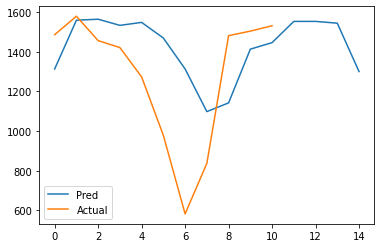

In [ ]:
h0_pred = torch.zeros(layer_dim, batch_size, hidden_dim)
fut_pred = 15
model.eval()
test_inp = []
for i in range(fut_pred):
  to_pred = torch.FloatTensor(data_test[i:i+train_window])
  to_pred = torch.reshape(to_pred, (batch_size, train_window, input_dim))
  seq = to_pred
  with torch.no_grad():
      test_inp.append([model(seq, h0_pred)[0], 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation
#print(test_inp)

#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))

stats_df = []
for i in for_plot_pred:
  stats_df.append(i)
print(stats)
plt.plot(stats)
plt.plot(stats_df)
plt.legend(['Pred', 'Actual'])
plt.show()

In [ ]:
stats = pd.DataFrame(stats)
stats.to_csv("RNN_TG.csv")


### **VAR** Model

In [ ]:
from statsmodels.tsa.api import VAR

df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data = (df.values)
data = pd.DataFrame(data)
print(data.shape)
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:239].to_numpy()
label_train = data.loc[:239, 2].to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = data.loc[240:].to_numpy()
label_test = data.loc[240:, 2].to_numpy()


cols = df.columns

Var = VAR(endog = data_train)
Var_fit = Var.fit()
#print(Var.score(data_test,label_test))
prediction = Var_fit.forecast(data_test, steps=len(data_test))

#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,3):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

print(pred)
d = []
for i in range(15):
  d.append(prediction[i][2])
#check rmse
print('rmse value for Daily Deceased is : ', sqrt(metrics.mean_squared_error(d, data.loc[240:, 2].to_numpy())))
plt.plot(data.loc[240:, 2].to_numpy())
plt.plot(d)
plt.show()


r = []
for i in range(15):
  r.append(prediction[i][1])
#check rmse
print('rmse value for Daily Recovered is : ', sqrt(metrics.mean_squared_error(r, data.loc[240:, 1].to_numpy())))
plt.plot(data.loc[240:, 1].to_numpy())
plt.plot(r)
plt.show()


c = []
for i in range(15):
  c.append(prediction[i][0])
#check rmse
print('rmse value for Daily Confirmed is : ', sqrt(metrics.mean_squared_error(c, data.loc[240:, 0].to_numpy())))
plt.plot(data.loc[240:, 0].to_numpy())
plt.plot(c)
plt.show()

### **SVR** Model

Multivariate - Daily_Confirmed Prediction

In [ ]:
from sklearn.svm import SVR
# Get data function
'''
def get_data(df):  
    data = df_.copy()
    data['Date'] = data['Date'].str.split('-').str[1]
    data['Date'] = pd.to_numeric(data['Date'])
    return [ data['Date'].tolist(), data['Daily Confirmed'].tolist() ] # Convert Series to list
dates, dc = get_data(df)
#print(dates, dc)
'''

Svr=SVR(kernel='rbf', C=2, gamma= 0.5)   # Parameter Tuning to get the best accuracy

# Intuitively, the gamma defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
# The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. 
# For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
# A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. 
# In other words C behaves as a regularization parameter in the SVM.

Svr.fit(data_train,label_train)
print(Svr.score(data_test,label_test))
Y_pred = Svr.predict(data_test)

test_inp = []
for i in Y_pred:
  test_inp.append([i, 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation
print(test_inp)

#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
from math import sqrt
from sklearn import metrics
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))

a = dfc_mh[221:236]
stats_df = []
for i in a:
  stats_df.append(i)
print(stats)

error = sqrt(metrics.mean_squared_error(stats_df,stats)) #calculate rmse
print('RMSE value of the SVR Model is:', error)

plt.plot(stats)
plt.plot(stats_df)
plt.legend(['Pred', 'Actual'])
plt.show()

Multivaraite - Daily_Recovered Prediction

In [ ]:
from sklearn.svm import SVR
df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data = sc.fit_transform(df.values)
data = pd.DataFrame(data)
print(data.shape)
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:239].to_numpy()
label_train = data.loc[:239, 1].to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = data.loc[240:].to_numpy()
label_test = data.loc[240:, 1].to_numpy() #df.loc[240:,'Daily Confirmed'].to_numpy()


Svr=SVR(kernel='rbf', C=2, gamma= 0.5)   # Parameter Tuning to get the best accuracy

# Intuitively, the gamma defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
# The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. 
# For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
# A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. 
# In other words C behaves as a regularization parameter in the SVM.

Svr.fit(data_train,label_train)
print(Svr.score(data_test,label_test))
Y_pred = Svr.predict(data_test)

test_inp = []
for i in Y_pred:
  test_inp.append([i, 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation


#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
#print(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))

a = df['Daily Recovered'].loc[240:255]
stats_df = []
for i in a:
  stats_df.append(i)

error = sqrt(metrics.mean_squared_error(stats_df,stats)) #calculate rmse
print('RMSE value of the SVR Model is:', error)

plt.plot(stats)
plt.plot(stats_df)
plt.legend(['Pred', 'Actual'])
plt.show()

Multivariate - Daily_Deceased Prediction

In [ ]:
from sklearn.svm import SVR
df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data = sc.fit_transform(df.values)
data = pd.DataFrame(data)
print(data.shape)
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:239].to_numpy()
label_train = data.loc[:239, 2].to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = data.loc[240:].to_numpy()
label_test = data.loc[240:, 2].to_numpy() #df.loc[240:,'Daily Confirmed'].to_numpy()


Svr=SVR(kernel='rbf', C=1, gamma= 0.3)   # Parameter Tuning to get the best accuracy

# Intuitively, the gamma defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
# The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. 
# For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
# A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. 
# In other words C behaves as a regularization parameter in the SVM.

Svr.fit(data_train,label_train)
print(Svr.score(data_test,label_test))
Y_pred = Svr.predict(data_test)

test_inp = []
for i in Y_pred:
  test_inp.append([i, 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation
#print(test_inp)

#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))
#print(actual_predictions)
a = df['Daily Deceased'].loc[240:255]
stats_df = []
for i in a:
  stats_df.append(i)

error = sqrt(metrics.mean_squared_error(stats_df,stats)) #calculate rmse
print('RMSE value of the SVR Model is:', error)


plt.plot(stats)
plt.plot(stats_df)
plt.legend(['Pred', 'Actual'])
plt.show()

### **Polynomial Regression** Model

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline



df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data = sc.fit_transform(df.values)
data = pd.DataFrame(data)
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:239].to_numpy()
label_train = data.loc[:239, 0].to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = data.loc[240:].to_numpy()
label_test = data.loc[240:, 0].to_numpy() #df.loc[240:,'Daily Confirmed'].to_numpy()



model = make_pipeline(PolynomialFeatures(1), Ridge())
model.fit(data_train, label_train)
Y_pred = model.predict(data_test)
print(Y_pred)

test_inp = []
for i in Y_pred:
  test_inp.append([i, 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation
#print(test_inp)

#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))
#print(actual_predictions)
print(stats)
a = df['Daily Confirmed'].loc[240:255]
stats_df = []
for i in a:
  stats_df.append(i)

error = sqrt(metrics.mean_squared_error(stats_df,stats)) #calculate rmse
print('RMSE value of the SVR Model is:', error)


plt.plot(stats)
plt.plot(stats_df)
plt.legend(['Pred', 'Actual'])
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn

df = pd.read_csv("Train.csv")
data1 = df.drop(['InvoiceDate','InvoiceNo'],1, inplace= False)
data1.head()

#Take targate variable into y
y = data1['UnitPrice']
X = data1.drop(['UnitPrice', "Country", "CustomerID"],axis = 1)

from sklearn.preprocessing import PowerTransformer
y = y.values.reshape(-1,1)
# power transform the raw data
power = PowerTransformer(method='yeo-johnson', standardize=True)
y = power.fit_transform(y)

# Split data into train and test format
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

from sklearn.ensemble import RandomForestRegressor
    
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

plt.plot(rf.feature_importances_)
plt.xticks(np.arange(X_train.shape[1]), X_train.columns.tolist(), rotation=90);


In [ ]:
dft = pd.read_csv("Test.csv")
datat = dft.drop(['InvoiceDate','InvoiceNo'],1, inplace= False)

#Take targate variable into y
#X = datat.drop(["Country", "CustomerID"],axis = 1)

y_pred =rf.predict(X)
print(y_pred)

In [ ]:
# Applying inverse power transform to get back original form of unit price
y_pred = y_pred.reshape(-1,1)
a_inverse_transformed = power.inverse_transform(y_pred)
a_inverse_transformed


In [ ]:
result = pd.DataFrame(data=a_inverse_transformed).round(2)
result.head()

In [ ]:
result.to_excel("MachineHack_UnitPricePrediction.xlsx")

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import sklearn
import matplotlib.pyplot as plt

#Take targate variable into y
y_ = data1['UnitPrice']
x_ = data1.drop(['UnitPrice', "Country", "CustomerID"],axis = 1)

sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
dt = sc.fit_transform(x_.values)
dt = pd.DataFrame(dt)
print(dt.shape)

X_train, X_test, y_train, y_test = train_test_split(dt, y_, test_size=0.2, random_state=None)

data_train = X_train.to_numpy()
label_train = y_train.to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = X_test.to_numpy()
label_test = y_test.to_numpy()
# ------------------------------> HYPERPARAMETERS <-------------------------------------
input_dim = 3
hidden_dim = 10
n_layers = 3
batch_size = 1
pred_time = 1 
train_window = 5
output_dim = pred_time

class GRUNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
#----------------------------> Creating Dataloader <----------------------------------------------------
def create_inout_sequences(input_data, input_label, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_label[i+tw:i+tw+1]
        train_seq = torch.reshape(train_seq, (batch_size, tw, input_dim))
        train_label = torch.reshape(train_label, (batch_size, pred_time, 1))
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# -----------------------------------------> LOADING DATA <----------------------------------------------
train_data_tensor = torch.FloatTensor(data_train)
label_data_tensor = torch.FloatTensor(label_train)
train_inout_seq = create_inout_sequences(train_data_tensor, label_data_tensor, train_window)

test_data_tensor = torch.FloatTensor(data_test)
label_test_data_tensor = torch.FloatTensor(label_test)
test_inout_seq = create_inout_sequences(test_data_tensor, label_test_data_tensor, train_window)
# -----------------> Defining model, loss class & optimizer <-------------------
model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#-------------------------------------------------------------------------------
epochs = 100
h0 = torch.zeros(n_layers, batch_size, hidden_dim)
h0_t = torch.zeros(n_layers, batch_size, hidden_dim)
#-------------------------------> Training loop <------------------------------
for i in range(epochs):
    for seq, labels in train_inout_seq:
      optimizer.zero_grad()
      y_pred, h0 = model(seq, h0)
      single_loss = loss_function(y_pred, labels)
      single_loss.backward()
      h0 = h0.detach()
      optimizer.step()
    if i%24 == 0:
        model.eval()
        for seq_t, labels_t in test_inout_seq:
          y_pred_t, _ = model(seq_t, h0_t)
          test_loss = loss_function(y_pred_t, labels_t)
        print(f'Epoch: {i+1:2}---> Training:- Loss: {single_loss.item():10.8f} ----- Testing:- Loss: {test_loss.item():10.8f}')
        model.train()

In [ ]:
h0_pred = torch.zeros(n_layers, batch_size, hidden_dim)
fut_pred = 10
model.eval()
test_inp = []
for i in range(fut_pred):
  to_pred = torch.FloatTensor(data_test[i:i+train_window])
  to_pred = torch.reshape(to_pred, (batch_size, train_window, input_dim))
  seq = to_pred
  with torch.no_grad():
      test_inp.append([model(seq, h0_pred)[0], 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation
print(test_inp)

#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))

print(stats)
'''
a = df['Daily Confirmed'].loc[240:249]
stats_df = []
for i in a:
  stats_df.append(i)
'''



## **Plots (Data Description)**

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

'''
s = "Crime Type Summer|Crime Type Winter".split("|")

# Generate dummy data into a dataframe
j = {x: [random.choice(["ASB", "Violence", "Theft", "Public Order", "Drugs"]
                       ) for j in range(300)] for x in s}
df = pd.DataFrame(j)
'''
df = pd.read_csv("state_wise_final.csv")
index = np.arange(10)
bar_width = 0.2

cf = df["Confirmed"]
dt = df["Deaths"]
rc = df["Recovered"]
st = df["State"]

fig, ax = plt.subplots(figsize=(20, 10))

#fig.figure(figsize(15, 4))

Confirmed = ax.bar(index, (cf[1:11]/cf[0])*100, bar_width, label="Confirmed", color="orange")
Deaths = ax.bar(index+bar_width, (rc[1:11]/rc[0])*100, bar_width, label="Recovered", color="green")
Deaths = ax.bar(index+(2*bar_width), (dt[1:11]/dt[0])*100, bar_width, label="deaths", color = "red")
ax.set_xlabel('States')
ax.set_ylabel('Cases in %')
ax.set_title('Comparison of Actual Data of 15 States')
ax.set_xticks(index + 2*bar_width / 2)
ax.set_xticklabels(st[1:11], rotation=90)
ax.legend()

plt.show()

In [ ]:
states = ["MH", "KA", "AP", "TN", "UP", "KL", "DL", "WB", "OR", "TG"]
df = ["df1", "df2", "df3", "df4", "df5", "df6", "df7", "df8", "df9", "df10"]
for i in range(10):
  df[i] = pd.read_csv("RNN_"+states[i]+".csv")


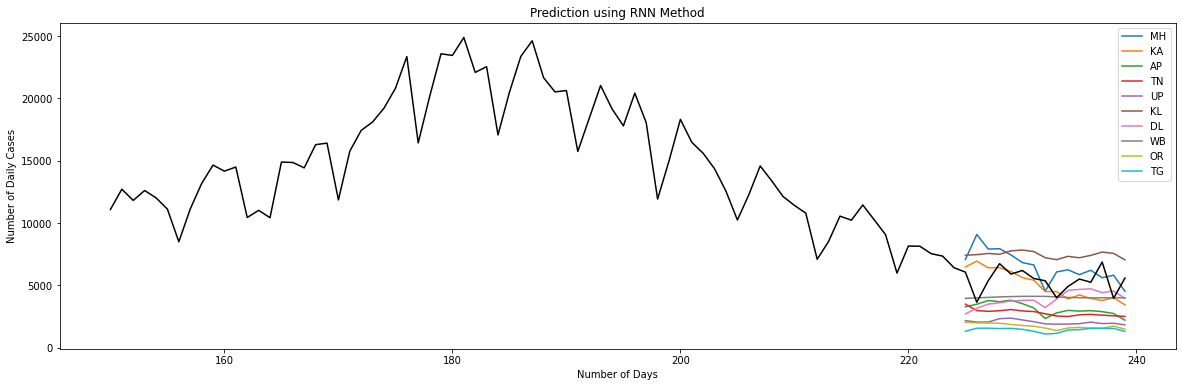

In [ ]:
fig,(a1) = plt.subplots(figsize=(20, 6))
x = np.arange(225, 240)
for i in range(10):
  a1.plot(x, df[i].iloc[:, 1], label=states[i], )
a1.plot(dfcmh, color="black")
a1.set_ylabel("Number of Daily Cases")
a1.set_xlabel("Number of Days")
a1.set_title("Prediction using RNN Method")
a1.legend()  
plt.show()

In [ ]:
dfl = pd.read_csv("sorted_data_state_daily.csv")
dfmh = dfl["MH"]
dfcmh = dfmh[:225]
print(dfcmh)
a = []
for i in range(len(dfcmh)+1):
  a.append(dfcmh[:i].sum())
print((a))

0        14
1        18
2         6
3         3
4         3
       ... 
220    8151
221    8142
222    7539
223    7347
224    6417
Name: MH, Length: 225, dtype: int64
[0, 14, 32, 38, 41, 44, 48, 52, 64, 74, 97, 107, 122, 125, 156, 186, 203, 220, 302, 335, 423, 487, 635, 747, 868, 1018, 1135, 1364, 1574, 1761, 1982, 2334, 2680, 2916, 3201, 3321, 3648, 4200, 4666, 5218, 5649, 6427, 6817, 7628, 8068, 8590, 9318, 9915, 10498, 11506, 12296, 12974, 14541, 15525, 16758, 17974, 19063, 20228, 22171, 23401, 24427, 25922, 27524, 29100, 30706, 33053, 35058, 37136, 39297, 41642, 44582, 47190, 50231, 52667, 54758, 56948, 59546, 62228, 65168, 67655, 70013, 72300, 74860, 77793, 80229, 82968, 85975, 88529, 90787, 94041, 97648, 101141, 104568, 107958, 110744, 113445, 116752, 120504, 124331, 128205, 132075, 135796, 139010, 142899, 147741, 152765, 159133, 164626, 169883, 174761, 180298, 186626, 192990, 200064, 206619, 211987, 217121, 223724, 230599, 238461, 246600, 254427, 260924, 267665, 275640, 284281,

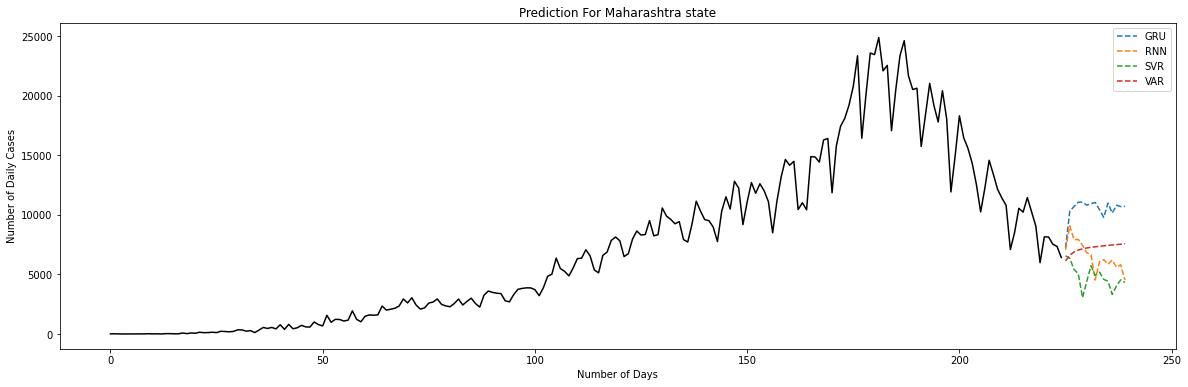

In [ ]:
fig,(a2) = plt.subplots(figsize=(20, 6))
z = pd.read_csv("GRU_MH.csv")
v = pd.read_csv("RNN_MH.csv")
b = pd.read_csv("SVR_MH.csv")
n = pd.read_csv("VAR_MH.csv")
z = z.iloc[:15, 1]
v = v.iloc[:, 1]
b = b.iloc[2:, 1]
n = n.iloc[:, 1]
a2.plot(x, z, "--", label = "GRU")
a2.plot(x, v, "--", label = "RNN")
a2.plot(x, b, "--", label = "SVR")
a2.plot(x, n, "--", label = "VAR")

a2.plot(dfcmh, color="black")
a2.set_ylabel("Number of Daily Cases")
a2.set_xlabel("Number of Days")
a2.set_title("Prediction For Maharashtra state")
a2.legend()  
plt.show()

[4562.666666666667, 701.5333333333333, 2380.4, 502.2, 692.2666666666667, 1053.2, 899.1333333333333, 598.6, 270.1333333333333, 365.93333333333334]


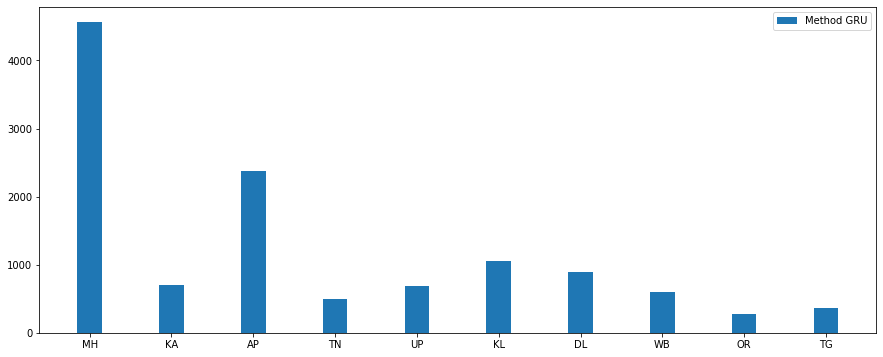

In [ ]:
fig, (a3) = plt.subplots(figsize=(15, 6))
dtfr = pd.read_csv("sorted_data_state_daily.csv")

states = ["MH", "KA", "AP", "TN", "UP", "KL", "DL", "WB", "OR", "TG"]
df = ["df1", "df2", "df3", "df4", "df5", "df6", "df7", "df8", "df9", "df10"]
dfs = ["df1", "df2", "df3", "df4", "df5", "df6", "df7", "df8", "df9", "df10"]
mae_mh = []
for i in range(10):
  df[i] = pd.read_csv("GRU_"+states[i]+".csv")
  dfs[i] = dtfr[states[i]].iloc[220:235]
  mae_mh.append(sklearn.metrics.mean_absolute_error(df[i].iloc[:, 1], dfs[i]))
print(mae_mh)
#index = np.arange(14)
bar_width = 0.3

a3.bar(states, mae_mh, bar_width, label="Method GRU")
a3.legend()

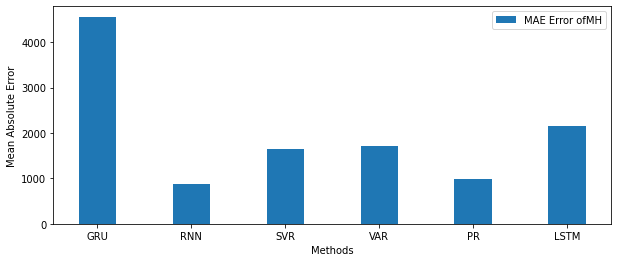

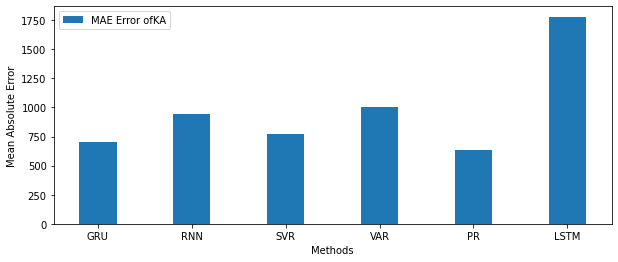

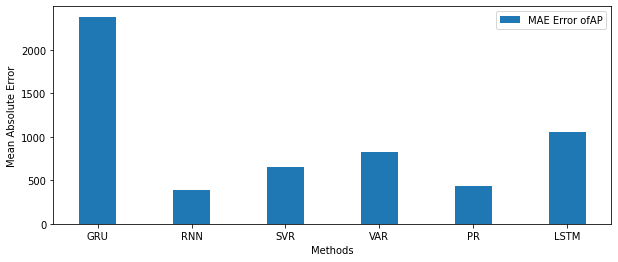

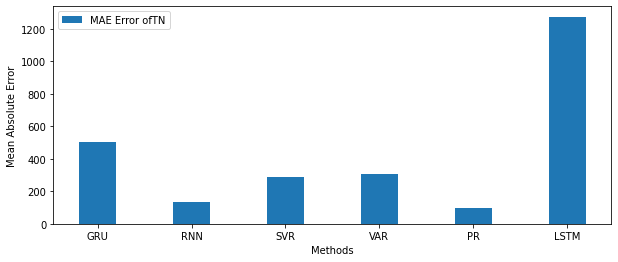

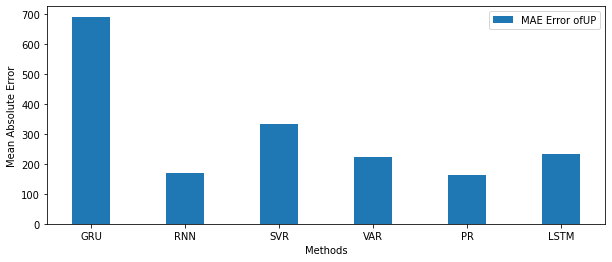

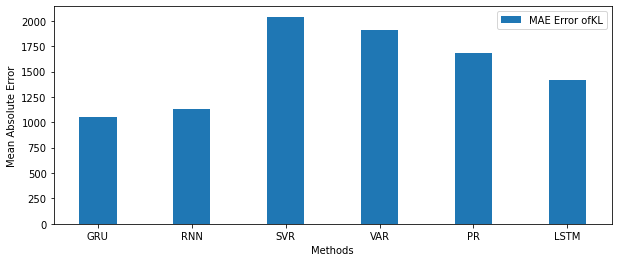

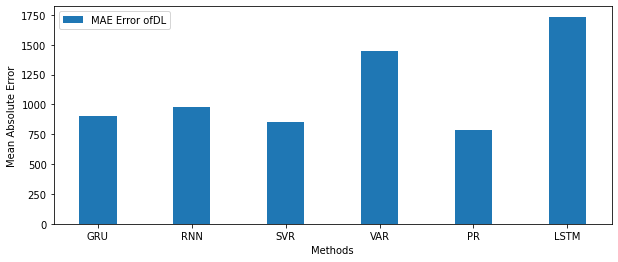

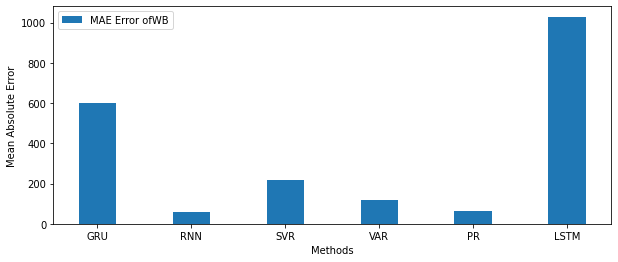

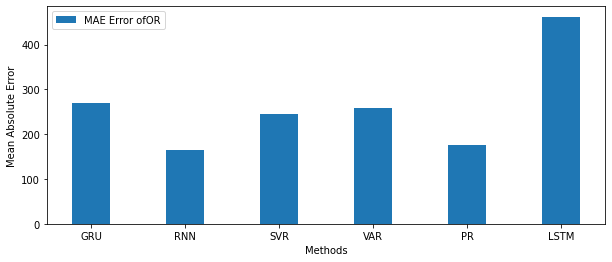

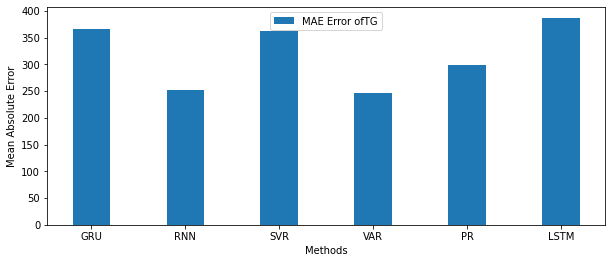

In [ ]:
dtfr = pd.read_csv("sorted_data_state_daily.csv")
dfs = ["df1", "df2", "df3", "df4", "df5", "df6", "df7", "df8", "df9", "df10"]
methods = ["GRU", "RNN", "SVR", "VAR", "PR", "LSTM"]
a = ["a1", "a2", "a3", "a4", "a5", "a6", "a7", "a8", "a9", "a10"]
states = ["MH", "KA", "AP", "TN", "UP", "KL", "DL", "WB", "OR", "TG"]
a = np.arange(10)

for i in range(10):
  maes = []
  dfs[i] = dtfr[states[i]].iloc[220:235]
  df = ["df1", "df2", "df3", "df4", "df5", "df6", "df7"]
  for j in range(6):
    df[j] = pd.read_csv(methods[j]+"_"+states[i]+".csv").iloc[:15, 1]
    maes.append(sklearn.metrics.mean_absolute_error(dfs[i], df[j]))
  fig, (a1) = plt.subplots(figsize=(10, 4))

  a1.bar(methods, maes, 0.4, label="MAE Error of"+ states[i])
  a1.set_ylabel("Mean Absolute Error")
  a1.set_xlabel("Methods")
  a1.legend()

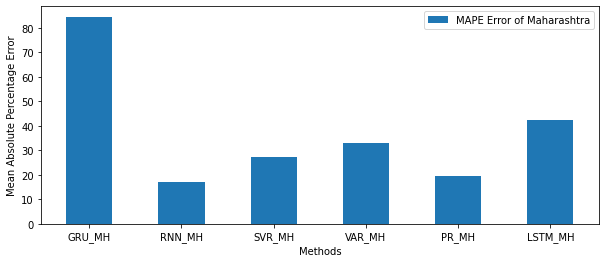

In [ ]:
fig, (a4) = plt.subplots(figsize=(10, 4))
dtfr = pd.read_csv("sorted_data_state_daily.csv")

import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  


z = pd.read_csv("GRU_MH.csv")
v = pd.read_csv("RNN_MH.csv")
b = pd.read_csv("SVR_MH.csv")
n = pd.read_csv("VAR_MH.csv")
l = pd.read_csv("LSTM_MH.csv")
z = z.iloc[:, 1]
v = v.iloc[:, 1]
b = b.iloc[2:, 1]
n = n.iloc[:, 1]
l = l.iloc[:, 1]
p = [7824, 7636, 6708, 6344, 3789, 5623, 7031, 6182, 6478, 5816, 5630, 4183, 5146, 5772, 5501]

maes = []
methods = ["GRU_MH", "RNN_MH", "SVR_MH", "VAR_MH", "PR_MH", "LSTM_MH"]
maes.append(mean_absolute_percentage_error(dfs[0], z))
maes.append(mean_absolute_percentage_error(dfs[0], v))
maes.append(mean_absolute_percentage_error(dfs[0], b))
maes.append(mean_absolute_percentage_error(dfs[0], n))
maes.append(mean_absolute_percentage_error(dfs[0], p))
maes.append(mean_absolute_percentage_error(dfs[0], l))

a4.bar(methods, maes, 0.5, label= "MAPE Error of Maharashtra")
a4.set_ylabel("Mean Absolute Percentage Error")
a4.set_xlabel("Methods")
a4.legend()

In [ ]:
import seaborn as sns
maes = np.array(maes)
mae = maes.T
dataframe = pd.DataFrame(mae, columns=methods)
sns.barplot(data = dataframe , x = "Methods", y = "Mean Absolute Error")

ValueError: ignored

In [ ]:
z = pd.read_csv("GRU_MH.csv").iloc[:, 1]
z

0     10325
1     10693
2     11065
3     11059
4     10809
5     10937
6     11039
7     10429
8      9778
9     10984
10    10146
11    10807
12    10697
13    10711
14    10289
Name: 0.1, dtype: int64